# Latent Dirichlet Allocation (LDA)

Lino Galiana  
2024-10-31

Cette page approfondit les exercices présentés dans la
[section précédente](#nlpexo).
On va ainsi continuer notre exploration de la littérature anglophones :

-   Edgar Allan Poe, (EAP) ;
-   HP Lovecraft (HPL) ;
-   Mary Wollstonecraft Shelley (MWS).

Les données sont disponibles dans la base de
données [spooky.csv](https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/blob/master/data/spooky.csv) et peuvent être
importées par `Python` en utilisant directement l’url
<https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/raw/master/data/spooky.csv>.

Le but va être dans un premier temps de regarder dans le détail les termes les plus fréquents utilisés par les auteurs, et les représenter graphiquement.

Ce notebook est librement inspiré de :

-   https://www.kaggle.com/enerrio/scary-nlp-with-spacy-and-keras
-   https://github.com/GU4243-ADS/spring2018-project1-ginnyqg
-   https://www.kaggle.com/meiyizi/spooky-nlp-and-topic-modelling-tutorial/notebook

La LDA est une technique d’estimation bayésienne.
Le [cours d’Alberto Brietti](http://alberto.bietti.me/files/rapport-lda.pdf)
sur le sujet constitue une très bonne ressource pour comprendre
les fondements de cette technique.

# 1. Librairies nécessaires

Cette page évoquera les principales librairies pour faire du NLP, notamment :

-   [WordCloud](https://github.com/amueller/word_cloud)
-   [NLTK](https://www.nltk.org/)
-   [SpaCy](https://spacy.io/)
-   [Keras](https://keras.io/)
-   [TensorFlow](https://www.tensorflow.org/)

<div class="alert alert-warning" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-lightbulb"></i> Hint</h3>

Comme dans la [partie précédente](#nlpexo), il faut télécharger quelques
éléments pour que `NTLK` puisse fonctionner correctement. Pour cela, faire:

``` python
import nltk

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("genesis")
nltk.download("omw-1.4")
```

</div>

Installations préalables :

In [1]:
!pip install wordcloud
!pip install pyLDAvis

La liste des modules à importer est assez longue, la voici :

In [2]:
import nltk

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("genesis")
nltk.download("wordnet")
nltk.download("omw-1.4")

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# from IPython.display import display
import base64
import string
import re
import nltk

from collections import Counter
from time import time

# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation


[nltk_data] Downloading package stopwords to /github/home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /github/home/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /github/home/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package genesis to /github/home/nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package wordnet to /github/home/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /github/home/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!

# 2. Données utilisées

*Si vous avez déjà lu la section précédente et importé les données, vous
pouvez passer à la section suivante*

Le code suivant permet d’importer le jeu de données `spooky`:

In [3]:
import pandas as pd

url = "https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/raw/master/data/spooky.csv"
import pandas as pd

train = pd.read_csv(url, encoding="latin-1")
train.columns = train.columns.str.capitalize()

train["ID"] = train["Id"].str.replace("id", "")
train = train.set_index("Id")


Le jeu de données met ainsi en regard un auteur avec une phrase qu’il a écrite:

In [4]:
train.head()


Les étapes de *preprocessing* sont expliquées dans le [chapitre précédent](#nlpexo). On applique les étapes suivantes :

1.  Tokeniser
2.  Retirer la ponctuation et les stopwords
3.  Lemmatiser le texte

In [5]:
lemma = WordNetLemmatizer()

train_clean = (
    train.groupby(["ID", "Author"])
    .apply(lambda s: nltk.word_tokenize(" ".join(s["Text"])))
    .apply(lambda words: [word for word in words if word.isalpha()])
)

from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

train_clean = train_clean.apply(
    lambda words: [lemma.lemmatize(w) for w in words if not w in stop_words]
).reset_index(name="tokenized")

train_clean.head(2)


/tmp/ipykernel_8292/2725603950.py:5: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


# 3. Principe de la LDA (Latent Dirichlet Allocation)

Le modèle **Latent Dirichlet Allocation (LDA)** est un modèle probabiliste génératif qui permet
de décrire des collections de documents de texte ou d’autres types de données discrètes. LDA fait
partie d’une catégorie de modèles appelés *“topic models”*, qui cherchent à découvrir des structures
thématiques cachées dans des vastes archives de documents.

Ceci permet d’obtenir des méthodes
efficaces pour le traitement et l’organisation des documents de ces archives : organisation automatique
des documents par sujet, recherche, compréhension et analyse du texte, ou même résumer des
textes.

Aujourd’hui, ce genre de méthodes s’utilisent fréquemment dans le web, par exemple pour
analyser des ensemble d’articles d’actualité, les regrouper par sujet, faire de la recommandation
d’articles, etc.

La LDA est une méthode qui considère les corpus comme des **mélanges** de sujets et
de mots. Chaque document peut être représenté comme le résultat d’un mélange :

-   de sujets
-   et, au sein de ces sujets, d’un choix de mots.

L’estimation des
paramètres de la LDA passe par l’estimation des distributions des variables
latentes à partir des données observées (*posterior inference*).
Mathématiquement, on peut se représenter la LDA comme une
technique de maximisation de *log vraisemblance* avec un algorithme EM (*expectation maximisation*)
dans un modèle de mélange.

La matrice termes-documents qui sert de point de départ est la suivante :

|       | word_1 | word_2 | word_3 | …   | word_J |
|-------|--------|--------|--------|-----|--------|
| doc_1 | 3      | 0      | 1      | …   | 0      |
| …     | …      | …      | …      | …   | …      |
| doc_N | 1      | 0      | 0      | …   | 5      |

On dit que cette matrice est *sparse* (creuse en Français) car elle contient principalement des 0. En effet, un document n’utilise qu’une partie mineure du vocabulaire complet.

La LDA consiste à transformer cette matrice *sparse* document-terme en deux matrices de moindre dimension :

1.  Une matrice document-sujet
2.  Une matrice sujet-mots

En notant $K_i$ le sujet $i$. On obtient donc

-   Une **matrice document-sujet** ayant la structure suivante :

|       | K_1 | K_2 | K_3 | …   | K_M |
|-------|-----|-----|-----|-----|-----|
| doc_1 | 1   | 0   | 1   | …   | 0   |
| …     | …   | …   | …   | …   | …   |
| doc_N | 1   | 1   | 1   | …   | 0   |

-   Une **matrice sujets-mots** ayant la structure suivante :

|     | word_1 | word_2 | word_3 | …   | word_J |
|-----|--------|--------|--------|-----|--------|
| K_1 | 1      | 0      | 0      | …   | 0      |
| …   | …      | …      | …      | …   | …      |
| K_M | 1      | 1      | 1      | …   | 0      |

Ces deux matrices ont l’interprétation suivante :

-   La première nous renseigne sur la présence d’un sujet dans un document
-   La seconde nous renseigne sur la présence d’un mot dans un sujet

En fait, le principe de la LDA est de construire ces deux matrices à partir des fréquences d’apparition des mots dans le texte.

On va se concentrer sur Edgar Allan Poe.

In [6]:
corpus = train_clean[train_clean["Author"] == "EAP"]


# 4. Entraîner une LDA

Il existe plusieurs manières d’entraîner une LDA.

Nous allons utiliser `Scikit` ici avec la méthode `LatentDirichletAllocation`.
Comme expliqué dans la partie [modélisation](#modelisation) :

1.  On initialise le modèle ;
2.  On le met à jour avec la méthode `fit`.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(
    stop_words="english"
)  # Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(
    corpus["tokenized"].apply(lambda s: " ".join(s))
)

# Tweak the two parameters below
number_topics = 5
number_words = 10  # Create and fit the LDA model
lda = LatentDirichletAllocation(
    n_components=11,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
    n_jobs=1,
)
lda.fit(count_data)


# 5. Visualiser les résultats

On peut déjà commencer par utiliser une fonction pour afficher les
résultats :

In [8]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[: -n_top_words - 1 : -1]]))


print_topics(lda, count_vectorizer, number_words)



Topic #0:
life man say direction business lady good mean turn held

Topic #1:
hand room door heard house open right window machine went

Topic #2:
thought shall time day mind night looked corpse hour say

Topic #3:
heart sure voice oh ha ah term apparent sake vessel

Topic #4:
thing minute sound look low distinct bug color dat dream

Topic #5:
quite account come really madame feeling sir monsieur wonder use

Topic #6:
little great eye say like man foot let way long

Topic #7:
said object friend nature word dupin letter movement replied possible

Topic #8:
body earth purpose atmosphere respect cause suppose chamber surface moon

Topic #9:
know human scarcely particular case drawer public principle appearance knowledge

Topic #10:
left manner thousand end saw state head people arm said

La représentation sous forme de liste de mots n’est pas la plus pratique…

On peut essayer de se représenter un *wordcloud* de chaque sujet pour mieux voir si cette piste est pertinente :

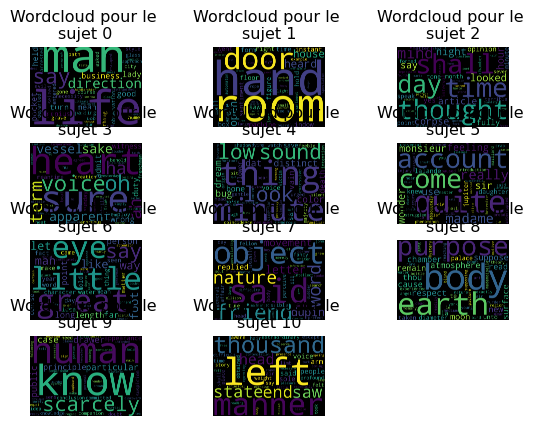

In [9]:
tf_feature_names = count_vectorizer.get_feature_names_out()


def wordcloud_lda(lda, tf_feature_names):

    fig, axs = plt.subplots(len(lda.components_) // 3 + 1, 3)

    for i in range(len(lda.components_)):
        corpus_lda = lda.components_[i]
        first_topic_words = [
            tf_feature_names[l] for l in corpus_lda.argsort()[: -50 - 1 : -1]
        ]
        k = i // 3
        j = i - k * 3
        wordcloud = WordCloud(
            stopwords=stop_words, background_color="black", width=2500, height=1800
        )
        wordcloud = wordcloud.generate(" ".join(first_topic_words))
        axs[k][j].set_title("Wordcloud pour le \nsujet {}".format(i))
        axs[k][j].axis("off")
        axs[k][j].imshow(wordcloud)

    r = len(lda.components_) % 3
    [
        fig.delaxes(axs[len(lda.components_) // 3, k - 1])
        for k in range(r + 1, 3 + 1)
        if r != 0
    ]


wc = wordcloud_lda(lda, tf_feature_names)
wc


In [10]:
wc


Le module `pyLDAvis` offre quelques visualisations bien pratiques lorsqu’on
désire représenter de manière synthétique les résultats d’une LDA et observer la distribution sujet x mots.

<div class="alert alert-warning" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-lightbulb"></i> Hint</h3>

Dans un *notebook* faire :

``` python
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()
```

Pour les utilisateurs de Windows, il est nécessaire d’ajouter l’argument
`n_jobs = 1`. Sinon, `Python` tente d’entraîner le modèle avec de la
parallélisation. Le problème est que les processus sont des `FORKs`, ce que
Windows ne supporte pas. Sur un système `Unix` (Linux, Mac OS), on peut se passer de cet
argument.

</div>

In [11]:
#!pip install pyLDAvis #à faire en haut du notebook sur colab
import pyLDAvis
import pyLDAvis.lda_model

# pyLDAvis.enable_notebook()
vis_data = pyLDAvis.lda_model.prepare(lda, count_data, count_vectorizer, n_jobs=1)
pyLDAvis.display(vis_data)


-   Chaque **bulle** représente un sujet. Plus la bulle est grande, plus il y a de documents qui traitent de ce sujet.

Plus les barres sont loin les unes des autres, plus elles sont différentes. Un bon modèle aura donc tendance à avoir de grandes bulles qui ne se recoupent pas. Ce n’est pas vraiment le cas ici…

-   Les **barres bleues** représentent la fréquence de chaque mot dans le corpus.

-   Les **barres rouges** représentent une estimation du nombre de termes générés dans un sujet précis. La barre rouge la plus longue correspond au mot le plus utilisé dans ce sujet.

# 6. Références

-   Le [poly d’Alberto Brietti](http://alberto.bietti.me/files/rapport-lda.pdf)